In [ ]:
#######################################################################################
# Project "Developing predictive models for COVID-19 diagnosis in paediatric patients: 
#          A case study about the potentials of Machine Learning in Public Health"
#          By Anna Mas-Casadesús (https://github.com/amascasadesus)
#          July 2020
#
#          Notebook 4/6
#######################################################################################

### Import basic modules & datasets

In [1]:
import pandas as pd
import numpy as np
import warnings
from warnings import simplefilter
warnings.filterwarnings('ignore')
simplefilter(action='ignore', category=FutureWarning)

In [2]:
Xsel_train = pd.read_csv('symptoms_paediatric_pp2_Xsel_train.csv')
ysel_train = pd.read_csv('symptoms_paediatric_pp2_ysel_train.csv')
Xsel_test = pd.read_csv('symptoms_paediatric_pp2_Xsel_test.csv')
ysel_test = pd.read_csv('symptoms_paediatric_pp2_ysel_test.csv')
Xsel_trainres = pd.read_csv('symptoms_paediatric_pp2_Xsel_trainres.csv')
ysel_trainres = pd.read_csv('symptoms_paediatric_pp2_ysel_trainres.csv')
# Create checkpoints:
Xsel_train = Xsel_train.copy()
ysel_train = ysel_train.copy()
Xsel_test = Xsel_test.copy()
ysel_test = ysel_test.copy()
Xsel_trainres = Xsel_trainres.copy()
ysel_trainres = ysel_trainres.copy()

### Modelling pipelines

A machine learning pipeline is used to help automate machine learning workflows by integrating and iterating several steps to train a model. 

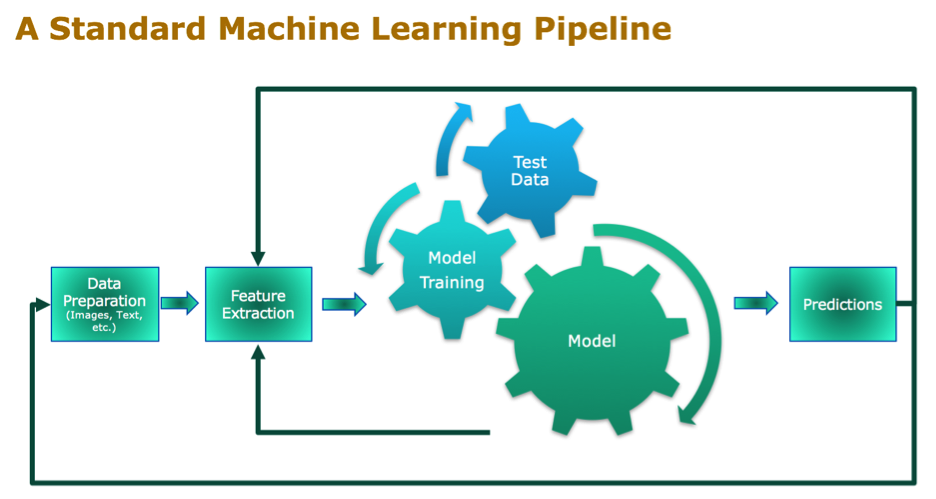

#### All models pipeline

Includes several machine learning classification models, from more simpler models such as Logistic Regression or Decision Tree to more complex ones like Random Forest or eXtra Gradient Boosting. In particular, we trained the following algorithms, hypertuning the appropiate parameters for each one (see below for details): 

        # Logistic Regression (LG) 
        # k-Nearest Neighbors (kNN)
        # Support Vector Machine - Classifier (SVM)
        # Decision Tree (DT)
        # Random Forest (RF)
        # eXtra Gradient Boosting (XGB)

Given the big amount of models to train considering all the parameters specifications, we decided to adopt a **RandomizedSearch strategy**. Contrary to GridSearch, in which every combination of paramater values are tried, RandomSearch sets up a grid of parameters and selects random combinations to train the model and score. 

To evaluate the different output models, we will use the **F1 score** or harmonic mean of the precision (i.e.  proportion of relevant instances correctly classified - true positives/true positives+false positives) and recall (i.e. proportion of  the total amount of relevant instances correctly classified - true positives/true postitives+false negatives). F1 score reaches its best value at 1 (perfect precision and recall). In particular, we used the F1 micro score, which calculate metrics globally by counting the total true positives, false negatives and false positives.

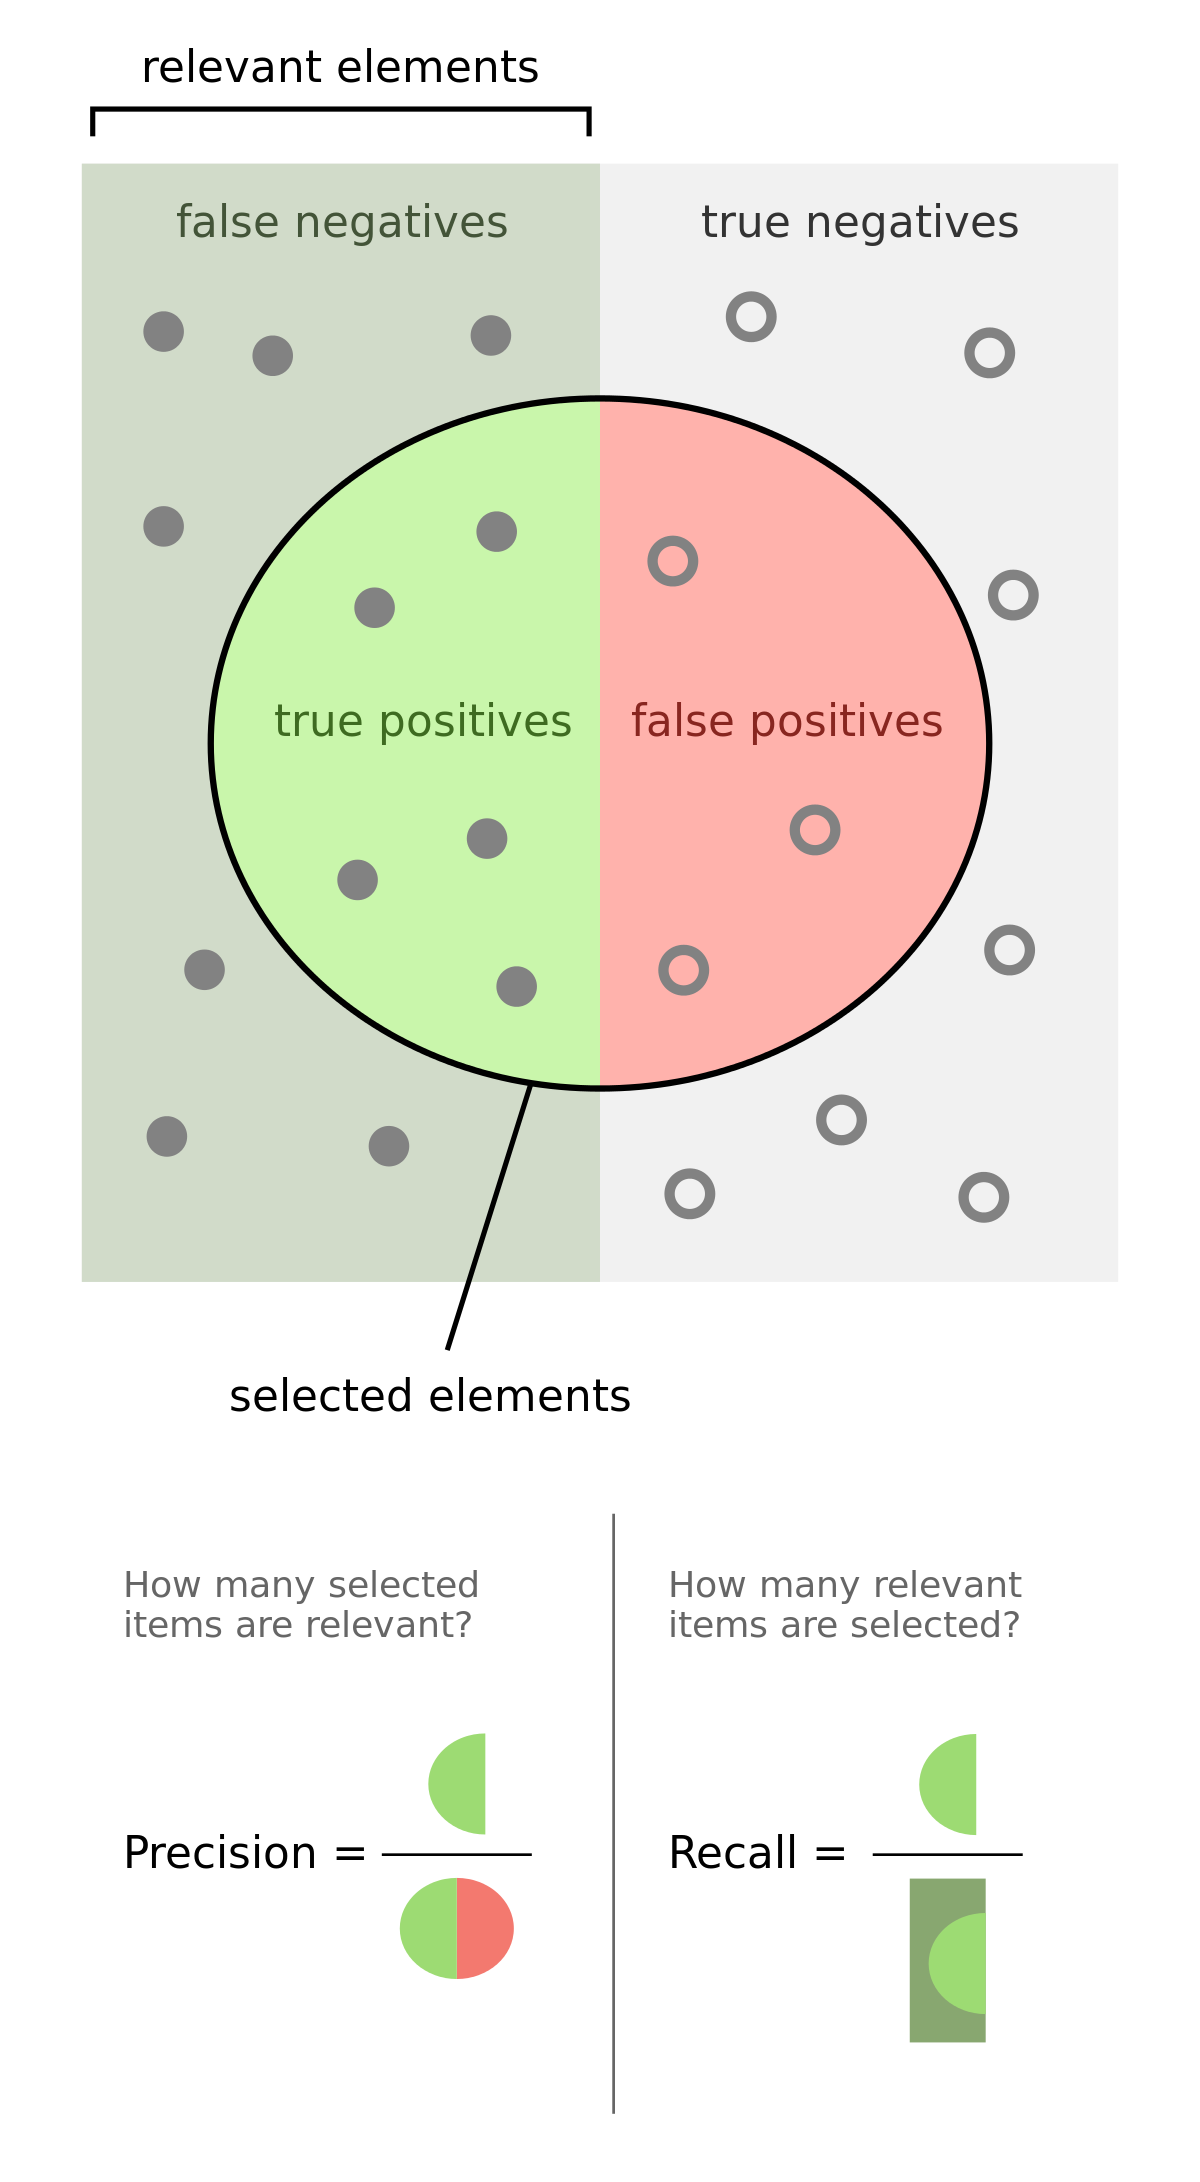

References on the different models used and how to hypertuning their parameters:
* ML models https://towardsdatascience.com/which-machine-learning-model-to-use-db5fdf37f3dd
* ML models https://www.edureka.co/blog/classification-in-machine-learning/
* ML models for mixed datasets https://www.quora.com/Which-machine-learning-algorithms-are-appropriate-for-numerical-categorical-or-both-values
* ML models for mixed datasets https://datascience.stackexchange.com/questions/418/best-way-to-classify-datasets-with-mixed-types-of-attributes/442#442
* ML models for mixed datasets https://stackoverflow.com/questions/14274771/choosing-classification-algorithm-to-classify-mix-of-nominal-and-numeric-data
* ML models for mixed datasets https://stats.stackexchange.com/questions/368046/which-algorithms-for-mixed-type-datasets-binary-classification
* LG https://select-statistics.co.uk/blog/analysing-categorical-data-using-logistic-regression-models/#:~:text=Similar%20to%20linear%20regression%20models,Driver%20Analysis%20for%20more%20information)
* kNN https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761
* kNN https://towardsdatascience.com/a-simple-introduction-to-k-nearest-neighbors-algorithm-b3519ed98e
* DT, RF, & XGB https://www.activestate.com/blog/comparing-decision-tree-algorithms-random-forest-vs-xgboost/
* RF https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6 
* RF & XGB https://towardsdatascience.com/the-ultimate-guide-to-adaboost-random-forests-and-xgboost-7f9327061c4f
* XGB https://www.datacamp.com/community/tutorials/xgboost-in-python
* XGB https://xgboost.readthedocs.io/en/latest/parameter.html#
* SVM https://towardsdatascience.com/a-guide-to-svm-parameter-tuning-8bfe6b8a452c 

In [7]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
import joblib
import time
import xgboost as xgb

start = time.time()

# Define the combinations of xy variables (i.e. subsets)
xy_sel = [Xsel_trainres, Xsel_test, ysel_trainres, ysel_test]
xy_selor = [Xsel_train, Xsel_test, ysel_train, ysel_test]
xy_list = [xy_sel, xy_selor]
xy_liststr = ["xy_sel", "xy_selor"]

# Built pipelines
pipe_lr = Pipeline([('clf', LogisticRegression())])
pipe_knn = Pipeline([('clf', KNeighborsClassifier())])
pipe_svm = Pipeline([('clf', svm.SVC())])
pipe_dt = Pipeline([('clf', DecisionTreeClassifier())])
pipe_rf = Pipeline([('clf', RandomForestClassifier())])
pipe_xgb = Pipeline([('clf', xgb.XGBClassifier())])

# Set grid search parameters
param_range_1 = [int(x) for x in np.linspace(0.001, 10, num=100)] # cost
param_range_2 = [int(x) for x in np.linspace(2, 10, num=9)] # n_neigghbors, max_dexpth, min_samples_leaf 
param_range_3 = [int(x) for x in np.linspace(2, 20, num=19)] # min_samples_split
param_range_4 = [int(x) for x in np.linspace(0, 1, num=20)] # learning_rate
param_range_5 = [int(x) for x in np.linspace(0.2, 0.8, num=6)] # colsample_bytree
param_range_6 = [int(x) for x in np.linspace(0, 5, num=10)] # min_child_weight
param_range_7 = [int(x) for x in np.linspace(0, 0.1, num=5)] # gamma
param_range_8 = [int(x) for x in np.linspace(3, 10, num=8)] # n_estimators
grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
                   'clf__C': param_range_1,
                   'clf__solver': ['liblinear', 'saga', 'lbfgs']}] 
grid_params_knn = [{'clf__n_neighbors': param_range_2}]
grid_params_svm = [{'clf__kernel': ['linear', 'rbf'],
                    'clf__gamma': ['auto','scale'],
                    'clf__C': param_range_1}]
grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
                   'clf__splitter': ['best','random'],
                   'clf__min_samples_leaf': param_range_2,
                   'clf__max_depth': param_range_2, 
                   'clf__min_samples_split': param_range_3}]
grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],              
                   'clf__min_samples_leaf': param_range_2, 
                   'clf__max_depth': param_range_2, 
                   'clf__min_samples_split': param_range_3}]            
grid_params_xgb = [{'clf__objective': ['reg:logistic'],
                    'clf__subsample': [0.5],
                    'clf__max_depth': param_range_2,
                    'clf__learning_rate': param_range_4,
                    'clf__colsample_bytree': param_range_5,
                    'clf__min_child_weight': param_range_5,
                    'clf__gamma': param_range_7,
                    'clf__n_estimators': param_range_8}] 

# Built grid searches
kfold = StratifiedKFold(n_splits=10, random_state=42)
gs_lr = RandomizedSearchCV(estimator=pipe_lr,
                     param_distributions=grid_params_lr,
                     scoring='f1_micro',
                     cv=kfold) 
gs_knn = RandomizedSearchCV(estimator=pipe_knn,
                     param_distributions=grid_params_knn,
                     scoring='f1_micro',
                     cv=kfold)
gs_svm = RandomizedSearchCV(estimator=pipe_svm,
                      param_distributions=grid_params_svm,
                      scoring='f1_micro',
                      cv=kfold)
gs_dt = RandomizedSearchCV(estimator=pipe_dt,
                     param_distributions=grid_params_dt,
                     scoring='f1_micro',
                     cv=kfold) 
gs_rf = RandomizedSearchCV(estimator=pipe_rf,
                     param_distributions=grid_params_rf,
                     scoring='f1_micro',
                     cv=kfold) 
gs_xgb = RandomizedSearchCV(estimator=pipe_xgb,
                     param_distributions=grid_params_xgb,
                     scoring='f1_micro',
                     cv=kfold) 

# List of pipelines for ease of iteration
grids = [gs_lr, gs_knn, gs_svm, gs_dt, gs_rf, gs_xgb]

# Dictionary of pipelines and classifiers for ease of reference
grid_dict = {0: 'Logistic Regression', 
             1: 'k-Nearest Neighbors', 
             2: 'Support Vector Machine', 
             3: 'Decision Tree', 
             4: 'Random Forest',
             5: 'eXtra Gradient Boosting'}

# Fit the grid search objects
print('Performing model optimisations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
def getxsys(xy):  
    """
    Gets X_train, X_test, y_test, and y_test of each specific subset
    """
    X_train = xy[0]
    X_test = xy[1]
    y_train = xy[2]
    y_test = xy[3]
    return X_train, X_test, y_train, y_test # Outside the for loop to optimise processing
rounds_list = ["1st", "2nd" , "3rd", "4th", "5th"]
rounds_list_iter = iter(rounds_list)  # Iterates over rounds_list
for _ in range(0,5):
    round_num = next(rounds_list_iter) # Takes one round item per iteration in rounds_list_iter, sequentially 
    print('\nRound:', round_num)
    xy_liststr_iter = iter(xy_liststr) # Iteraves over xy_liststr
    for xy in xy_list:
        X_train, X_test, y_train, y_test = getxsys(xy)
        xy_str = next(xy_liststr_iter) # Takes one list name per iteration in xy_liststr_iter, sequentially 
        print('\n', xy_str)
        for idx, gs in enumerate(grids):
            print('\nEstimator: %s' % (grid_dict[idx]), xy_str)
            # Fit grid search
            gs.fit(X_train, y_train)
            # Best params
            print('Best params: %s' % gs.best_params_)
            # Best training data accuracy
            print('Best training F1 score: %.3f' % gs.best_score_)
            # Predict on test data with best params
            y_pred = gs.predict(X_test)
            # Test data accuracy of model with best params
            print('Test set F1 score for best params: %.3f ' % f1_score(y_test, y_pred, average='micro'))
            # Track best (highest test accuracy) model
            if accuracy_score(y_test, y_pred) > best_acc:
                best_acc = accuracy_score(y_test, y_pred)
                best_gs = gs
                best_clf = idx
                best_xy = xy_str
    print('\nClassifier with best test set F1 score: %s' % grid_dict[best_clf], best_xy)

end = time.time()
print('\nTotal execution time:', ((end - start)/60), 'min')

Performing model optimisations...

Round: 1st

 xy_sel

Estimator: Logistic Regression xy_sel
Best params: {'clf__solver': 'liblinear', 'clf__penalty': 'l1', 'clf__C': 3}
Best training F1 score: 0.933
Test set F1 score for best params: 0.655 

Estimator: k-Nearest Neighbors xy_sel
Best params: {'clf__n_neighbors': 4}
Best training F1 score: 0.933
Test set F1 score for best params: 0.690 

Estimator: Support Vector Machine xy_sel
Best params: {'clf__kernel': 'rbf', 'clf__gamma': 'scale', 'clf__C': 1}
Best training F1 score: 0.933
Test set F1 score for best params: 0.759 

Estimator: Decision Tree xy_sel
Best params: {'clf__splitter': 'random', 'clf__min_samples_split': 9, 'clf__min_samples_leaf': 5, 'clf__max_depth': 4, 'clf__criterion': 'entropy'}
Best training F1 score: 0.933
Test set F1 score for best params: 0.724 

Estimator: Random Forest xy_sel
Best params: {'clf__min_samples_split': 11, 'clf__min_samples_leaf': 3, 'clf__max_depth': 4, 'clf__criterion': 'entropy'}
Best training F

Best params: {'clf__solver': 'liblinear', 'clf__penalty': 'l1', 'clf__C': 3}
Best training F1 score: 0.933
Test set F1 score for best params: 0.655 

Estimator: k-Nearest Neighbors xy_sel
Best params: {'clf__n_neighbors': 4}
Best training F1 score: 0.933
Test set F1 score for best params: 0.690 

Estimator: Support Vector Machine xy_sel
Best params: {'clf__kernel': 'rbf', 'clf__gamma': 'scale', 'clf__C': 1}
Best training F1 score: 0.933
Test set F1 score for best params: 0.759 

Estimator: Decision Tree xy_sel
Best params: {'clf__splitter': 'random', 'clf__min_samples_split': 14, 'clf__min_samples_leaf': 4, 'clf__max_depth': 7, 'clf__criterion': 'entropy'}
Best training F1 score: 0.933
Test set F1 score for best params: 0.724 

Estimator: Random Forest xy_sel
Best params: {'clf__min_samples_split': 11, 'clf__min_samples_leaf': 2, 'clf__max_depth': 8, 'clf__criterion': 'gini'}
Best training F1 score: 0.910
Test set F1 score for best params: 0.759 

Estimator: eXtra Gradient Boosting xy_

We have executed the pipeline 3 times and **Random Forests** were clearly the best performing models through almost all iterations for both the oversampled and the original data.  

#### Reduced models pipeline

In order to find the best parameters for the selected Random Forests models, we will run a reduced pipeline which will only train Random Forests on both datasets (oversampled and original data), training the different parameters with **GridSearch strategy**. In addition, we will train a dummy classifier, which gives you a measure of “baseline” performance — i.e. the success rate one should expect to achieve even if simply guessing. 

Reference:

* https://medium.com/@mamonu/what-is-the-scikit-learn-dummy-classifier-95549d9cd44

In [8]:
from sklearn import svm
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
import joblib
import time

start = time.time()

# Define the combinations of xy variables (i.e. subsets)
xy_sel = [Xsel_trainres, Xsel_test, ysel_trainres, ysel_test]
xy_selor = [Xsel_train, Xsel_test, ysel_train, ysel_test]
xy_list = [xy_sel, xy_selor]
xy_liststr = ["xy_sel", "xy_selor"]

# Built pipelines
pipe_dummy = Pipeline([('clf', DummyClassifier(random_state=42))])
pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state=42))])

# Set grid search parameters
param_range_2 = [int(x) for x in np.linspace(2, 10, num=9)] # n_neigghbors, max_dexpth, min_samples_leaf 
param_range_3 = [int(x) for x in np.linspace(2, 20, num=19)] # min_samples_split
grid_params_dummy = [{'clf__strategy': ['most_frequent']}]
grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],              
                   'clf__min_samples_leaf': param_range_2, 
                   'clf__max_depth': param_range_2, 
                   'clf__min_samples_split': param_range_3}]            

# Built grid searches
kfold = StratifiedKFold(n_splits=10, random_state=42)
gs_dummy = GridSearchCV(estimator=pipe_dummy,
                     param_grid=grid_params_dummy,
                     scoring='f1_micro',
                     cv=kfold) 
gs_rf = GridSearchCV(estimator=pipe_rf,
                     param_grid=grid_params_rf,
                     scoring='f1_micro',
                     cv=kfold) 

# List of pipelines for ease of iteration
grids = [gs_dummy, gs_rf]

# Dictionary of pipelines and classifiers for ease of reference
grid_dict = {0: 'Performance baseline', 
             1: 'Random Forest'}

# Fit the grid search objects
print('Performing model optimisations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
def getxsys(xy):  
    """
    Gets X_train, X_test, y_test, and y_test of each specific subset
    """
    X_train = xy[0]
    X_test = xy[1]
    y_train = xy[2]
    y_test = xy[3]
    return X_train, X_test, y_train, y_test # Outside the for loop to optimise processing
xy_liststr_iter = iter(xy_liststr) # Iterates over xy_liststr
for xy in xy_list:
    X_train, X_test, y_train, y_test = getxsys(xy)
    xy_str = next(xy_liststr_iter) # Takes one list name per iteration in xy_liststr_iter, sequentially
    print('\n', xy_str)
    for idx, gs in enumerate(grids):
        print('\nEstimator: %s' % (grid_dict[idx]), xy_str)
        # Fit grid search
        gs.fit(X_train, y_train)
        # Best params
        print('Best params: %s' % gs.best_params_)
        # Best training data accuracy
        print('Best training F1 score: %.3f' % gs.best_score_)
        # Predict on test data with best params
        y_pred = gs.predict(X_test)
        # Test data accuracy of model with best params
        print('Test set F1 score for best params: %.3f ' % f1_score(y_test, y_pred, average='micro'))
        # Track best (highest test accuracy) model
        if accuracy_score(y_test, y_pred) > best_acc:
            best_acc = accuracy_score(y_test, y_pred)
            best_gs = gs
            best_clf = idx
            best_xy = xy_str
print('\nClassifier with best test set F1 score: %s' % grid_dict[best_clf], best_xy)

end = time.time()

print('\nTotal models executed: 6156')
print('\nTotal execution time:', ((end - start)/60), 'min')

Performing model optimisations...

 xy_sel

Estimator: Performance baseline xy_sel
Best params: {'clf__strategy': 'most_frequent'}
Best training F1 score: 0.456
Test set F1 score for best params: 0.793 

Estimator: Random Forest xy_sel
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}
Best training F1 score: 0.921
Test set F1 score for best params: 0.690 

 xy_selor

Estimator: Performance baseline xy_selor
Best params: {'clf__strategy': 'most_frequent'}
Best training F1 score: 0.773
Test set F1 score for best params: 0.793 

Estimator: Random Forest xy_selor
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 8}
Best training F1 score: 0.843
Test set F1 score for best params: 0.793 

Classifier with best test set F1 score: Performance baseline xy_sel

Total models executed: 6156

Total execution time: 162.58093278805416 min


 Results:
 
 - **Oversampled Model** best parameters = {'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}
 - **Original Model** best parameters = {'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 8}
 
The analyses also show that the Random Forest models clearly outperform the dummy classifier or baseline performances.